<a href="https://colab.research.google.com/github/nescoba/DIP/blob/main/vanillaSINDy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First attempt, or 'vanilla' SINDy

## Importing data and libraries, disregard

In [16]:
import seaborn as sns
import numpy as np

sns.set()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/data/10G.csv'

In [4]:
import pandas as pd

green10 = pd.read_csv(path, header=None)
green10.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11558,11559,11560,11561,11562,11563,11564,11565,11566,11567,11568,11569,11570,11571,11572,11573,11574,11575,11576,11577,11578,11579,11580,11581,11582,11583,11584,11585,11586,11587,11588,11589,11590,11591,11592,11593,11594,11595,11596,11597
0,0.1625,0.3125,0.7750,0.1250,0.9625,1.1625,0.8625,0.9375,0.7500,0.300,0.4125,0.5375,0.4875,0.4875,0.2000,0.9000,1.1625,0.3500,0.3250,0.5125,1.0875,-0.0375,-0.3625,0.8125,0.2875,0.2125,2.0375,0.7125,0.3000,0.7375,0.7875,0.9375,0.4375,0.8000,1.0500,-0.0125,-0.1625,0.4750,0.5375,0.4875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0875,0.7250,1.5875,0.7000,-0.1000,0.6875,NaN,NaN
1,0.4500,0.6000,0.8125,0.1625,0.2000,0.6625,1.0125,1.5250,1.2250,0.050,0.7500,0.8125,1.2000,0.4875,1.0500,1.2000,1.2875,1.4625,-0.1000,-0.2125,0.8125,0.2375,0.5500,0.3250,0.1875,1.3375,0.6125,1.3750,0.4375,1.6250,1.0750,0.1750,-0.2250,1.2125,1.0875,0.2500,0.1625,0.4375,0.7375,1.1125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.1750,1.1250,1.0125,0.3125,0.4875,NaN,NaN
2,0.7375,0.6000,0.6250,0.8125,0.7875,0.8500,0.2875,0.5500,0.1125,0.325,0.7125,0.2750,0.1875,0.1875,1.3125,1.2750,0.3875,0.9375,1.1250,2.3750,1.2500,0.6750,-0.3875,0.2375,0.8375,0.8375,0.5625,0.1000,1.0750,0.2375,0.5625,0.2000,0.6375,0.8625,1.1375,0.3250,0.3625,0.9375,0.8000,0.4875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7000,0.6500,0.5750,0.6875,0.9125,0.0000,NaN,NaN
3,0.5000,0.6125,0.3750,0.7000,1.3625,0.9250,1.3375,1.0500,0.2125,0.300,0.7250,0.5875,0.1500,1.2750,1.3500,0.5750,0.8250,0.8125,0.0875,-0.0250,0.2375,0.6875,1.0125,0.3125,0.8250,0.0125,0.0375,0.4375,0.7000,0.2375,0.3125,1.1875,0.2750,1.0875,0.7250,0.3375,0.5500,0.9625,-0.3500,0.6125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1500,0.7875,0.0000,0.5125,0.4875,1.0750,NaN,NaN
4,0.5625,0.6750,1.5375,0.6750,0.9125,1.6125,0.6875,0.3750,0.5875,0.375,0.2625,0.6750,0.4000,0.5125,-0.1375,0.0875,1.0500,1.0000,-0.2625,1.0375,0.6000,0.1625,0.3750,0.1250,0.6500,0.4375,1.2000,1.0500,0.8375,1.4625,0.3250,0.0875,0.4125,-0.1000,0.2625,0.7875,0.0375,0.7000,0.9625,1.5750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.2250,0.9875,0.4500,0.4625,1.8750,NaN,NaN


In [6]:
green10.shape

(144, 11598)

## EDA

Let's start by looking at a sample cell with MODIP=10. First, its green flourescence exhibits a bust around t=120

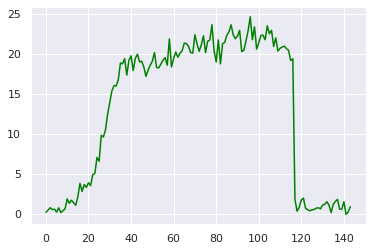

In [55]:
import matplotlib.pyplot as plt

plt.plot(green10[0], color='green')

Its 'derivative' shows the bust more clearly

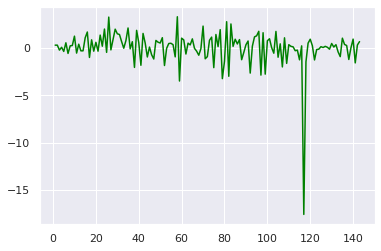

In [64]:
plt.plot(green10[0].diff(), color='green')

Let's import the red flourescence now

In [10]:
path2 = '/content/drive/MyDrive/data/10R.csv'
red10 = pd.read_csv(path2, header=None)
red10.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11558,11559,11560,11561,11562,11563,11564,11565,11566,11567,11568,11569,11570,11571,11572,11573,11574,11575,11576,11577,11578,11579,11580,11581,11582,11583,11584,11585,11586,11587,11588,11589,11590,11591,11592,11593,11594,11595,11596,11597
0,0.675,0.0000,-0.1125,0.0500,0.6625,0.1500,0.0625,0.4500,-0.025,-0.0250,0.3375,0.4625,0.0500,1.0250,0.3875,-0.1625,0.6500,0.4750,0.5875,0.1875,0.3375,0.3500,0.3250,0.4250,0.1375,0.5000,0.6375,0.5625,1.0875,0.3625,0.9875,0.2000,-0.4000,0.3875,1.1500,0.3500,0.4375,0.4500,-0.1250,0.3750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5625,-0.0875,1.4625,0.3375,0.9500,0.7750,NaN,NaN
1,0.000,0.5875,0.3625,0.9875,0.5750,-0.2500,0.2875,-0.2750,1.325,1.0625,-0.1875,-0.1000,0.6875,0.3125,0.0375,0.5750,0.2750,-0.2250,-0.2750,0.6500,0.8750,0.1750,0.1750,1.1875,-0.2375,0.0625,0.6250,0.4375,0.1125,0.7625,0.8125,0.7375,1.3375,0.1875,0.1375,0.4000,0.6375,1.4000,0.7750,0.1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0500,0.7375,0.1375,0.3875,0.6000,0.2125,NaN,NaN
2,0.700,0.6000,0.4500,0.1500,0.4500,0.3375,0.7500,0.6125,0.575,-0.0250,-0.1750,-0.1875,-0.1125,0.1375,0.3000,-0.2000,1.0375,0.7375,0.4000,0.5125,1.5000,0.0375,0.5375,1.2125,0.1875,0.2875,0.3375,0.9625,0.5250,1.6000,0.1250,0.9250,0.3625,0.6000,1.1250,1.1625,0.4625,0.6000,0.7125,0.9125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3750,0.8625,0.8125,0.2500,0.3125,0.7375,NaN,NaN
3,1.175,0.2000,0.1375,0.6875,0.6625,-0.2375,0.1750,0.2750,0.400,0.5250,0.5000,0.2625,1.5125,0.2500,0.2125,0.3250,0.3750,0.9500,0.1875,0.5750,0.5875,0.1500,1.0375,-0.0125,0.5375,0.4000,0.2250,1.0250,0.1250,1.0000,0.8250,0.5250,0.6250,-0.2125,0.9500,-0.0375,0.8625,0.1250,0.0875,0.5125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0375,0.3875,-0.2625,0.2250,0.9000,0.1625,NaN,NaN
4,0.325,0.0750,0.2375,0.6125,0.3250,0.8000,-0.2000,-0.3750,0.325,0.9500,-0.2125,1.1875,0.5500,1.1125,0.2125,1.3500,0.1875,0.7750,-0.2000,0.3125,0.0750,0.6000,-0.0500,0.6125,0.6250,0.2250,1.0125,0.3250,0.7750,0.3250,0.9875,0.4000,0.3375,0.0000,0.7000,0.3750,0.1375,0.3875,0.4000,0.4250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0250,0.0125,0.7375,0.5125,0.4875,0.6125,NaN,NaN


In [11]:
red10.shape

(144, 11598)

When we plot both flourescence, we see a problem. The red flourescence never 'took off' while the green one did. It's unlikely that the dynamics of both series are related. 

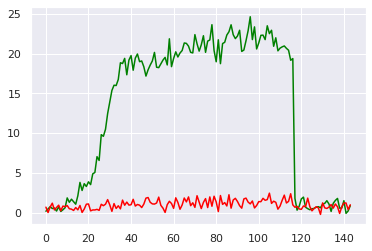

In [56]:
plt.plot(green10[0], color='green')
plt.plot(red10[0], color='red')

So, let's pick a different cell. Cell #10, to be precise

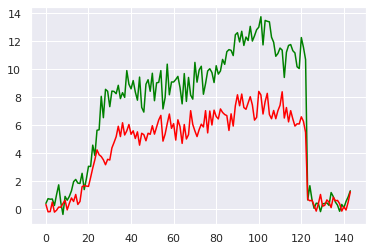

In [57]:
plt.plot(green10[10], color='green')
plt.plot(red10[10], color='red')

The two series seem more related to each other. 

Let us focus on the period of time before the burst, since that burst is probably difficult to model:

Text(0.5, 1.0, 'Cell #10, before bust, MODIP=10')

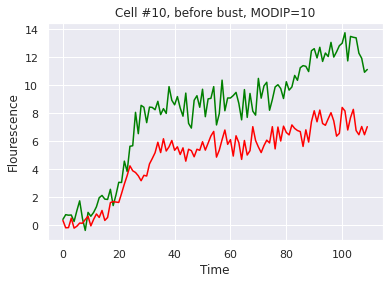

In [33]:
ts_g_10 = green10[10].iloc[:110]
ts_r_10 = red10[10].iloc[:110]

plt.plot(ts_g_10, color='green')
plt.plot(ts_r_10, color='red')
plt.xlabel('Time')
plt.ylabel('Flourescence')
plt.title('Cell #10, before bust, MODIP=10')

We can differentiate, in the sense of Time Series theory.

Text(0.5, 1.0, 'Cell #10, MODIP=10, before bust')

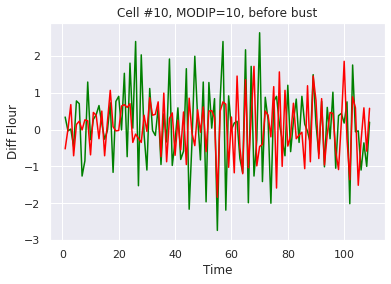

In [34]:
dtsg10 = ts_g_10.diff()[1:]
dtsr10 = ts_r_10.diff()[1:]

plt.plot(dtsg10, color='green')
plt.plot(dtsr10, color='red')
plt.xlabel('Time')
plt.ylabel('Diff Flour')
plt.title('Cell #10, MODIP=10, before bust')

In [35]:
dtsg10.shape

(109,)

In [36]:
dtsg10

1      0.3375
2     -0.0375
3      0.0125
4     -0.4625
5      0.7750
        ...  
105   -0.0375
106   -1.1000
107   -0.3625
108   -1.0000
109    0.2000
Name: 10, Length: 109, dtype: float64

The first entry is always a NAN, so let's drop it 

In [24]:
tsg10 = green10[10].iloc[1:110]
tsr10 = red10[10].iloc[1:110]

Let's assemble the design matrix for the regression. First, we put together the two time series, in the restricted range that we chose. 

In [25]:
X = pd.concat([tsg10, tsr10], axis=1)
X

,10,10
1,0.7500,-0.1875
2,0.7125,-0.1750
3,0.7250,0.5000
4,0.2625,-0.2125
5,1.0375,-0.0750
...,...,...
105,13.3875,6.7625
106,12.2875,6.4625
107,11.9250,7.0500
108,10.9250,6.4625


Then, we generate polynomial terms

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(5)
X = poly.fit_transform(X)
X

array([[ 1.00000000e+00,  7.50000000e-01, -1.87500000e-01, ...,
        -3.70788574e-03,  9.26971436e-04, -2.31742859e-04],
       [ 1.00000000e+00,  7.12500000e-01, -1.75000000e-01, ...,
        -2.72072021e-03,  6.68247070e-04, -1.64130859e-04],
       [ 1.00000000e+00,  7.25000000e-01,  5.00000000e-01, ...,
         6.57031250e-02,  4.53125000e-02,  3.12500000e-02],
       ...,
       [ 1.00000000e+00,  1.19250000e+01,  7.05000000e+00, ...,
         4.98292243e+04,  2.94587867e+04,  1.74158865e+04],
       [ 1.00000000e+00,  1.09250000e+01,  6.46250000e+00, ...,
         3.22139930e+04,  1.90556457e+04,  1.12720467e+04],
       [ 1.00000000e+00,  1.11250000e+01,  7.03750000e+00, ...,
         4.31375289e+04,  2.72881222e+04,  1.72620368e+04]])

Now, we perform Lasso regression

In [58]:
from sklearn.linear_model import Lasso

lassog = Lasso()
lassog.fit(X, dtsg10)

lassor = Lasso()
lassor.fit(X, dtsr10)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.591e+01, tolerance: 1.283e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+01, tolerance: 6.292e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso()

Let's look at the coefficients

In [59]:
lassog.coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  4.24638801e-03, -0.00000000e+00,
       -5.06138887e-03, -4.82430014e-03,  1.25191903e-06, -1.33070620e-04,
       -1.28568827e-04, -1.15388793e-04, -3.03702676e-04, -2.06625933e-05,
        9.75969927e-06,  1.94238577e-05,  3.08991010e-05,  4.09530511e-05,
        3.95470936e-05])

In [60]:
lassor.coef_

array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.04293113e-04, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -2.87041010e-05, -7.71851971e-05,
       -7.40087118e-05, -0.00000000e+00,  1.57405521e-05,  6.79284077e-06,
       -6.79064719e-06, -9.49485431e-06, -4.72247333e-06,  1.74915433e-05,
        1.05841741e-04])

As it common with Lasso regression, a bunch of them are exactly zero. So this is a relatively parsimoneous model 

## How accurate is this model?

First, let's look at the RMSE

In [45]:
dtsg10_pred = lassog.predict(X)
dtsr10_pred = lassor.predict(X)

In [46]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(dtsg10, dtsg10_pred))

1.0093979096678265

In [47]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(dtsr10, dtsr10_pred))

0.6596392468093446

Considering 

In [63]:
np.std(dtsg10), np.std(dtsr10)

(1.0848181736437938, 0.7597495672471585)

This is not good. The errors are of the order of magnitude of sd. 

Another diagnostic step is to plot the residuals of the model against the predicted values 

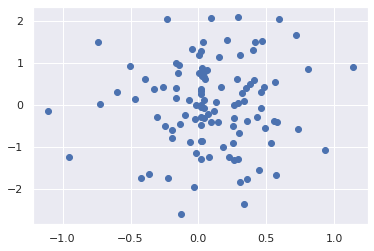

In [50]:
plt.scatter(dtsg10_pred, dtsg10 - dtsg10_pred)

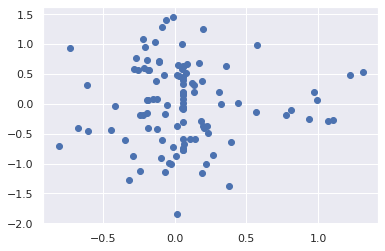

In [51]:
plt.scatter(dtsr10_pred, dtsr10 - dtsr10_pred)

At least these are not that bad. No curvature, a little  heteroskedasticity

## Other attempts 

### A different library

In [37]:
import statsmodels.api as sm

modelg = sm.OLS(dtsg10, X)
resultg = modelg.fit_regularized(alpha=1., L1_wt=1)

modelr = sm.OLS(dtsr10, X)
resultr = modelr.fit_regularized(alpha=1., L1_wt=1)

In [40]:
resultg.params

const    0.000000e+00
x1       0.000000e+00
x2       0.000000e+00
x3       2.233011e-03
x4       0.000000e+00
x5       0.000000e+00
x6       2.484885e-04
x7      -2.138697e-04
x8      -6.419348e-04
x9      -1.231177e-03
x10      2.763842e-05
x11      3.574091e-06
x12     -2.996090e-06
x13     -3.198481e-05
x14     -1.055149e-04
x15      0.000000e+00
x16      4.892239e-07
x17      3.161265e-06
x18      3.219137e-06
x19      1.120476e-06
x20     -6.145701e-06
dtype: float64

In [44]:
resultr.params

const    0.000000e+00
x1       0.000000e+00
x2       0.000000e+00
x3      -2.500721e-03
x4       0.000000e+00
x5       0.000000e+00
x6      -3.992566e-04
x7      -2.607166e-05
x8       1.527000e-04
x9       6.260507e-04
x10     -1.148309e-05
x11      5.713761e-06
x12      2.271558e-05
x13      5.832758e-05
x14      1.318368e-04
x15     -2.774484e-06
x16      3.100731e-07
x17      1.204802e-06
x18      3.324907e-06
x19      8.017025e-06
x20      1.776394e-05
dtype: float64

To my surprise, no other statistical tools are available with these library either. 

### OLS

What happens if we just use OLS?

One hand, the model will not be as parsimoneus. On the other hand, the model will be slightly less precise, but not by much. 

In [52]:
modelgsimple = sm.OLS(dtsg10, X)
resultgsimple = modelgsimple.fit()

modelrsimple = sm.OLS(dtsr10, X)
resultrsimple = modelrsimple.fit()

In [53]:
print(resultgsimple.summary())

                            OLS Regression Results                            
Dep. Variable:                     10   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.373
Date:                Thu, 24 Feb 2022   Prob (F-statistic):              0.158
Time:                        16:06:19   Log-Likelihood:                -148.74
No. Observations:                 109   AIC:                             339.5
Df Residuals:                      88   BIC:                             396.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6011      0.745     -0.807      0.4

In [54]:
print(resultrsimple.summary())

                            OLS Regression Results                            
Dep. Variable:                     10   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2.195
Date:                Thu, 24 Feb 2022   Prob (F-statistic):            0.00655
Time:                        16:06:41   Log-Likelihood:                -102.66
No. Observations:                 109   AIC:                             247.3
Df Residuals:                      88   BIC:                             303.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2152      0.488      0.441      0.6

This is not a great model for this data. 

We could integrate the predicted series to compare it to the original one. The model is capable of capturing the main dynamics, but it's not precise at all. 

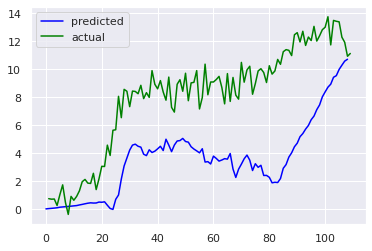

In [68]:
plt.plot(np.cumsum(dtsg10_pred), color='blue', label='predicted')
plt.plot(tsg10, color='green', label='actual')
plt.legend()

## Discussion

* If I implemented full SINDy, the results would be even less precise
  * making the model parsimoneous sacrifices accuracy, which is already lacking. 

* Why? 
    * bad estimates for the derivative 
    * series is not long enough, not a lot of data

* TODO
    * Stochastic SINDy



